In [3]:
import scipy.io

# Load the .mat file
boundary_ref2_mat = scipy.io.loadmat('matrix/boundary_ref2.mat')
boundary_tar2_mat = scipy.io.loadmat('matrix/boundary_tar2.mat')

# Print the keys to find out the matrix key
print(boundary_ref2_mat.keys())
print(boundary_tar2_mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'boundary'])
dict_keys(['__header__', '__version__', '__globals__', 'boundary'])


In [15]:
# Access your matrix using the 'boundary' key
boundary_ref = boundary_ref2_mat['boundary']
boundary_tar = boundary_tar2_mat['boundary']

print(boundary_ref)
print(boundary_tar)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


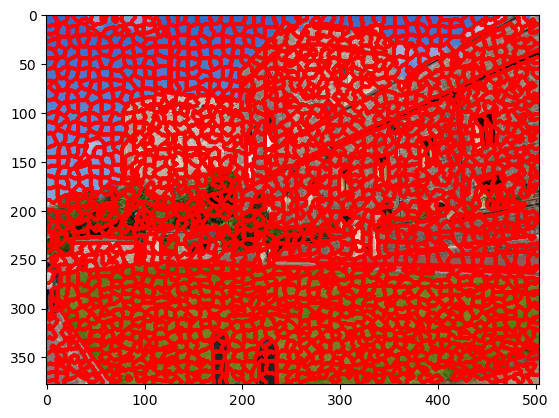

In [16]:
import matplotlib.pyplot as plt
import cv2

# Load the image
reference_image = cv2.imread('refrence-targets/reference2.jpg', cv2.IMREAD_COLOR)
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

# Assuming 'boundary' is a binary mask
# Display the image
plt.imshow(reference_image)
plt.contour(boundary_ref, colors='red')
plt.show()


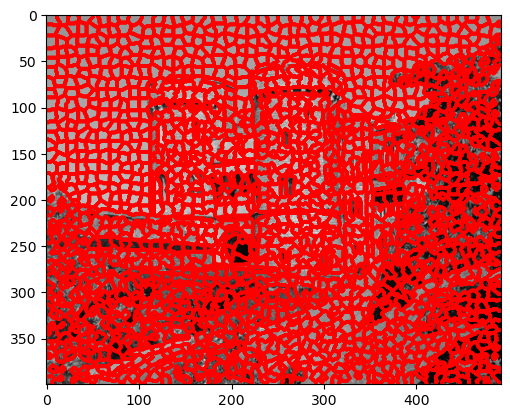

In [17]:
# Load the image
target_image = cv2.imread('refrence-targets/target2.jpg', cv2.IMREAD_GRAYSCALE)

# Assuming 'boundary' is a binary mask
# Display the image
plt.imshow(target_image, cmap='gray')
plt.contour(boundary_tar, colors='red')
plt.show()

In [ ]:
import numpy as np
from skimage.segmentation import find_boundaries

def boundary_to_superpixels(boundary_matrix):
    # Initialize the label matrix with zeros
    label_matrix = np.zeros_like(boundary_matrix, dtype=int)
    
    # Find the boundaries of the superpixels
    boundaries = find_boundaries(boundary_matrix, mode='inner')
    
    # Label each superpixel region
    label = 1
    for i in range(boundary_matrix.shape[0]):
        for j in range(boundary_matrix.shape[1]):
            if not boundaries[i, j] and label_matrix[i, j] == 0:
                # Perform flood fill to label the entire superpixel region
                flood_fill(boundary_matrix, label_matrix, i, j, label)
                label += 1
                
    return label_matrix

def flood_fill(boundary_matrix, label_matrix, x, y, label):
    stack = [(x, y)]
    while stack:
        i, j = stack.pop()
        if i < 0 or i >= boundary_matrix.shape[0] or j < 0 or j >= boundary_matrix.shape[1]:
            continue
        if label_matrix[i, j] != 0 or boundary_matrix[i, j] == 1:
            continue
        label_matrix[i, j] = label
        stack.append((i+1, j))
        stack.append((i-1, j))
        stack.append((i, j+1))
        stack.append((i, j-1))

In [21]:
reference_superpixels = boundary_to_superpixels(boundary_ref)
print(reference_superpixels)

target_superpixels = boundary_to_superpixels(boundary_tar)
print(target_superpixels)

[[   1    1    1 ...   46   46   46]
 [   1    1    1 ...   46   46   46]
 [   1    1    1 ...   46   46   46]
 ...
 [2107 2107 2107 ... 2087 2087 2087]
 [2107 2107 2107 ... 2087 2087 2087]
 [2107 2107 2107 ... 2087 2087 2087]]
[[   1    1    1 ...   44   44   44]
 [   1    1    1 ...   44   44   44]
 [   1    1    1 ...   44   44   44]
 ...
 [1991 1991 1991 ...    0 1966 1966]
 [1991 1991 1991 ... 1966    0 1966]
 [1991 1991 1991 ... 1966 1966 1966]]


In [22]:
print(f'number of superpixels in reference image: {np.max(reference_superpixels)}')
print(f'number of superpixels in target image: {np.max(target_superpixels)}')

number of superpixels in reference image: 2108
number of superpixels in target image: 2008


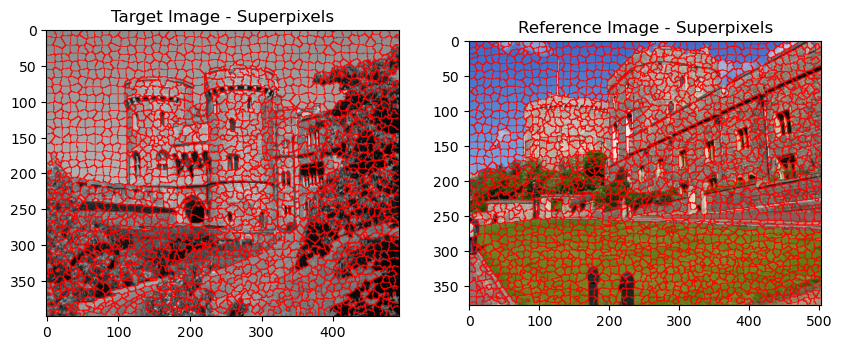

In [23]:
from skimage.segmentation import slic, mark_boundaries, find_boundaries

# Display Superpixel Boundaries
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mark_boundaries(target_image, target_superpixels, color=(1, 0, 0)))
ax[0].set_title("Target Image - Superpixels")
ax[1].imshow(mark_boundaries(reference_image, reference_superpixels, color=(1, 0, 0)))
ax[1].set_title("Reference Image - Superpixels")
plt.show()

using gabour only

2-Feature extraction

In [24]:
import numpy as np
from skimage.segmentation import slic, mark_boundaries, find_boundaries
from skimage.color import rgb2lab
import matplotlib.pyplot as plt
import cv2
from skimage.filters import gabor

In [25]:
# Function to extract features for each pixel
def extract_pixel_features(image):
    height, width = image.shape[:2]
    features = np.zeros((height, width, 40))  # Adjusted size for Gabor features

    # Ensure the image has three channels (RGB)
    if len(image.shape) == 2 or image.shape[2] == 1:
        gray_image = image
    else:
        # Compute intensity
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    features[:, :, 0] = gray_image

    # Compute Gabor features (magnitude)
    orientations = np.linspace(0, np.pi, 8, endpoint=False)
    scales = [np.exp(i) for i in range(5)]
    gabor_index = 0
    for scale in scales:
        for orientation in orientations:
            real, imag = gabor(gray_image, frequency=scale, theta=orientation)
            magnitude = np.sqrt(real**2 + imag**2)
            features[:, :, gabor_index] = magnitude
            gabor_index += 1

    return features

# Function to extract features for each superpixel
def extract_superpixel_features(image, superpixels):
    pixel_features = extract_pixel_features(image)
    features = {}
    unique_labels = np.unique(superpixels)

    for label in unique_labels:
        mask = (superpixels == label)
        superpixel_pixels = pixel_features[mask]

        # Compute mean feature vector for the superpixel
        mean_gabor = np.mean(superpixel_pixels[:, 1:], axis=0)  # Adjusted indices for Gabor features

        # Store features in a dictionary
        features[label] = {
            'gabor': mean_gabor
        }

    return features

In [26]:
# Extract features for target and reference images
target_features = extract_superpixel_features(target_image, target_superpixels)
reference_features = extract_superpixel_features(reference_image, reference_superpixels)


In [27]:
print(f"target_features: {target_features}")

target_features: {0: {'gabor': array([9.87655883, 9.73764013, 9.92696561, 9.40146439, 9.92624531,
       9.72791149, 9.89469197, 9.40640492, 9.40361179, 9.41086945,
       9.40230895, 9.40625343, 9.40230895, 9.41086945, 9.40361179,
       9.20621946, 9.20621946, 9.20621946, 9.20621946, 9.20621946,
       9.20621946, 9.20621946, 9.20621946, 9.40664281, 9.40664281,
       9.40664281, 9.40664281, 9.40664281, 9.40664281, 9.40664281,
       9.40664281, 9.39631744, 9.39631744, 9.39631744, 9.39631744,
       9.39631744, 9.39631744, 9.39631744, 9.39631744])}, 1: {'gabor': array([ 6.01425334, 11.65756202,  7.77063454, 10.35684041,  7.71183206,
       11.68642653,  5.92754055,  4.4190124 ,  4.4190124 ,  4.4190124 ,
        4.4190124 ,  4.4190124 ,  4.4190124 ,  4.4190124 ,  4.4190124 ,
        8.6865458 ,  8.6865458 ,  8.6865458 ,  8.6865458 ,  8.6865458 ,
        8.6865458 ,  8.6865458 ,  8.6865458 ,  9.60353053,  9.60353053,
        9.60353053,  9.60353053,  9.60353053,  9.60353053,  9.6035305

In [28]:
# Function to compute Euclidean distance between two feature vectors
def euclidean_distance(f1, f2):
    return np.linalg.norm(f1 - f2)

# Function to perform cascade feature matching using only Gabor features
def cascade_feature_matching(target_features, reference_features):
    matched_superpixels = {}

    for t_label, t_features in target_features.items():
        # Compute distances for Gabor features
        gabor_distances = {r_label: euclidean_distance(t_features['gabor'], r_features['gabor'])
                           for r_label, r_features in reference_features.items()}

        # Find the best match
        best_match = min(gabor_distances, key=gabor_distances.get)
        matched_superpixels[t_label] = best_match

    return matched_superpixels


optimized

In [29]:
# Function to perform cascade feature matching using only Gabor features
def cascade_feature_matching(target_features, reference_features):
    matched_superpixels = {}

    for t_label, t_features in target_features.items():
        # Compute distances for Gabor features and find the best match
        best_match = min(reference_features.items(), key=lambda r: euclidean_distance(t_features['gabor'], r[1]['gabor']))[0]
        matched_superpixels[t_label] = best_match

    return matched_superpixels

In [30]:
# Perform cascade feature matching
matched_superpixels = cascade_feature_matching(target_features, reference_features)

In [31]:
# Print matched superpixels
print("Matched Superpixels:")
for t_label, r_label in matched_superpixels.items():
    print(f"Target Superpixel {t_label} matched with Reference Superpixel {r_label}")

print(f"Number of matched superpixels: {len(matched_superpixels)} out of {len(target_features)}")

Matched Superpixels:
Target Superpixel 0 matched with Reference Superpixel 1180
Target Superpixel 1 matched with Reference Superpixel 666
Target Superpixel 2 matched with Reference Superpixel 666
Target Superpixel 3 matched with Reference Superpixel 667
Target Superpixel 4 matched with Reference Superpixel 704
Target Superpixel 5 matched with Reference Superpixel 686
Target Superpixel 6 matched with Reference Superpixel 685
Target Superpixel 7 matched with Reference Superpixel 686
Target Superpixel 8 matched with Reference Superpixel 686
Target Superpixel 9 matched with Reference Superpixel 686
Target Superpixel 10 matched with Reference Superpixel 736
Target Superpixel 11 matched with Reference Superpixel 738
Target Superpixel 12 matched with Reference Superpixel 738
Target Superpixel 13 matched with Reference Superpixel 738
Target Superpixel 14 matched with Reference Superpixel 746
Target Superpixel 15 matched with Reference Superpixel 1017
Target Superpixel 16 matched with Reference

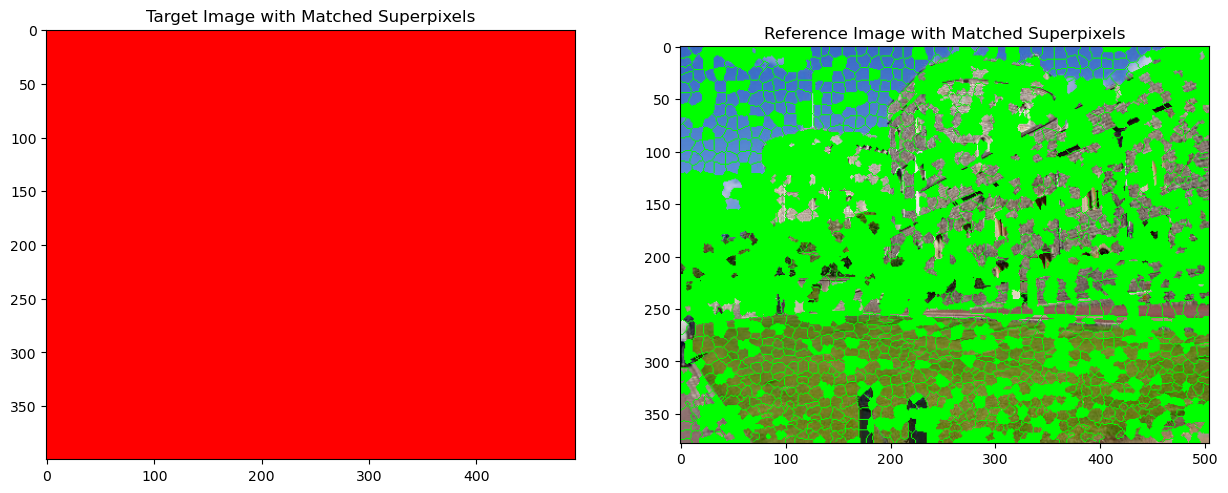

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Function to create a mask for the matched superpixels
def create_superpixel_mask(superpixels, matched_labels):
    mask = np.zeros(superpixels.shape, dtype=bool)
    for label in matched_labels:
        mask[superpixels == label] = True
    return mask

# Function to overlay dots on the matched superpixels
def overlay_dots(image, mask, color):
    overlay_image = image.copy()
    for c in range(3):  # Apply the color to each channel
        overlay_image[mask, c] = color[c]
    return overlay_image

# Create masks for the matched superpixels
target_matched_labels = list(matched_superpixels.keys())
reference_matched_labels = list(matched_superpixels.values())

target_mask = create_superpixel_mask(target_superpixels, target_matched_labels)
reference_mask = create_superpixel_mask(reference_superpixels, reference_matched_labels)

# Overlay dots on the original images
def overlay_dots(image, mask, color):
    overlay_image = image.copy()
    if len(overlay_image.shape) == 2:  # Grayscale image
        overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_GRAY2RGB)
    for c in range(3):  # Apply the color to each channel
        overlay_image[mask, c] = color[c]
    return overlay_image

target_image_with_dots = overlay_dots(target_image, target_mask, [255, 0, 0])  # Red dots
reference_image_with_dots = overlay_dots(reference_image, reference_mask, [0, 255, 0])  # Green dots

# Display the images with matched superpixels
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(target_image_with_dots)
ax[0].set_title("Target Image with Matched Superpixels")
ax[1].imshow(reference_image_with_dots)
ax[1].set_title("Reference Image with Matched Superpixels")
plt.show()

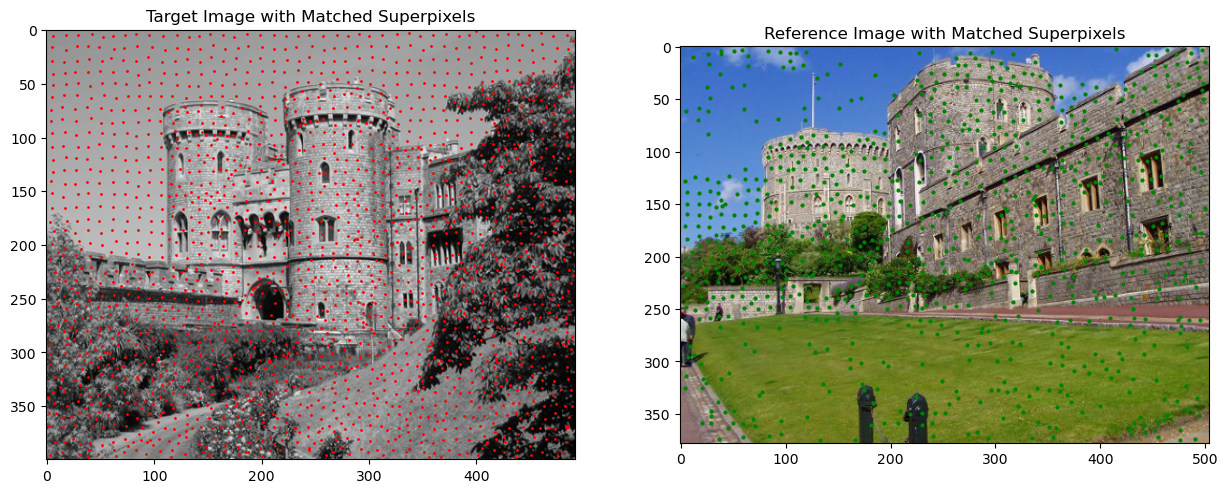

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# Function to create a mask for the matched superpixels
def create_superpixel_mask(superpixels, matched_labels):
    mask = np.zeros(superpixels.shape, dtype=bool)
    for label in matched_labels:
        mask[superpixels == label] = True
    return mask

# Function to get the centroids of the matched superpixels
def get_superpixel_centroids(superpixels, matched_labels):
    centroids = []
    for region in regionprops(superpixels):
        if region.label in matched_labels:
            centroids.append(region.centroid)
    return centroids

# Create masks for the matched superpixels
target_matched_labels = list(matched_superpixels.keys())
reference_matched_labels = list(matched_superpixels.values())

target_mask = create_superpixel_mask(target_superpixels, target_matched_labels)
reference_mask = create_superpixel_mask(reference_superpixels, reference_matched_labels)

# Get centroids of the matched superpixels
target_centroids = get_superpixel_centroids(target_superpixels, target_matched_labels)
reference_centroids = get_superpixel_centroids(reference_superpixels, reference_matched_labels)

# Display the images with matched superpixels
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(target_image, cmap='gray')
ax[0].set_title("Target Image with Matched Superpixels")
ax[1].imshow(reference_image)
ax[1].set_title("Reference Image with Matched Superpixels")

# Plot small markers at the centroids of the matched superpixels
for centroid in target_centroids:
    ax[0].plot(centroid[1], centroid[0], 'ro', markersize=1)  # Red dots
for centroid in reference_centroids:
    ax[1].plot(centroid[1], centroid[0], 'go', markersize=2)  # Green dots

plt.show()

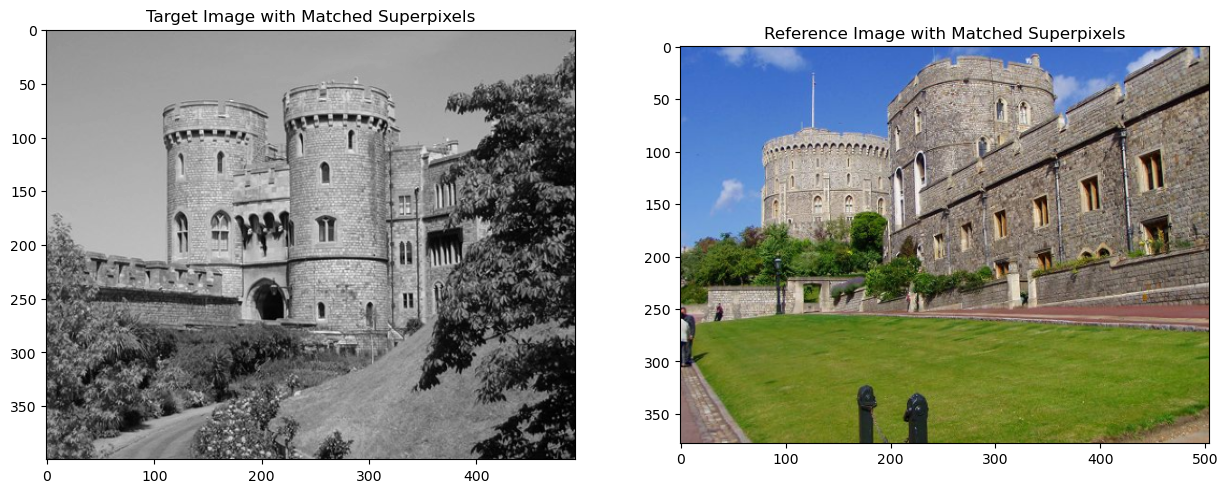

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops

# Function to create a mask for the matched superpixels
def create_superpixel_mask(superpixels, matched_labels):
    mask = np.zeros(superpixels.shape, dtype=bool)
    for label in matched_labels:
        mask[superpixels == label] = True
    return mask

# Function to get the centroids of the matched superpixels
def get_superpixel_centroids(superpixels, matched_labels):
    centroids = []
    for region in regionprops(superpixels):
        if region.label in matched_labels:
            centroids.append(region.centroid)
    return centroids

# Function to create a list of numbers from start to end with step 1
def create_number_list(start, end):
    return list(range(start, end + 1))

# Specify superpixels of interest
# superpixels_of_interest = [4000 - 5001]  
superpixels_of_interest = create_number_list(4800, 4900)

# Filter matched superpixels to include only those of interest
filtered_matched_superpixels = {t_label: r_label for t_label, r_label in matched_superpixels.items() if t_label in superpixels_of_interest}

# Create masks for the matched superpixels
target_matched_labels = list(filtered_matched_superpixels.keys())
reference_matched_labels = list(filtered_matched_superpixels.values())

target_mask = create_superpixel_mask(target_superpixels, target_matched_labels)
reference_mask = create_superpixel_mask(reference_superpixels, reference_matched_labels)

# Get centroids of the matched superpixels
target_centroids = get_superpixel_centroids(target_superpixels, target_matched_labels)
reference_centroids = get_superpixel_centroids(reference_superpixels, reference_matched_labels)

# Display the images with matched superpixels
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(target_image, cmap='gray')
ax[0].set_title("Target Image with Matched Superpixels")
ax[1].imshow(reference_image)
ax[1].set_title("Reference Image with Matched Superpixels")

# Plot small markers at the centroids of the matched superpixels
#colors: r:red, g:green, b:blue, c:cyan, m:magenta, y:yellow, k:black, w:white
for centroid in target_centroids:
    ax[0].plot(centroid[1], centroid[0], 'ro', markersize=5)  # Red dots
for centroid in reference_centroids:
    ax[1].plot(centroid[1], centroid[0], 'co', markersize=5)  # Green dots

plt.show()

Initial colorization

In [36]:
# Convert to Lab color space
target_lab = cv2.cvtColor(cv2.cvtColor(target_image, cv2.COLOR_GRAY2BGR), cv2.COLOR_BGR2Lab)
reference_lab = cv2.cvtColor(reference_image, cv2.COLOR_BGR2Lab)

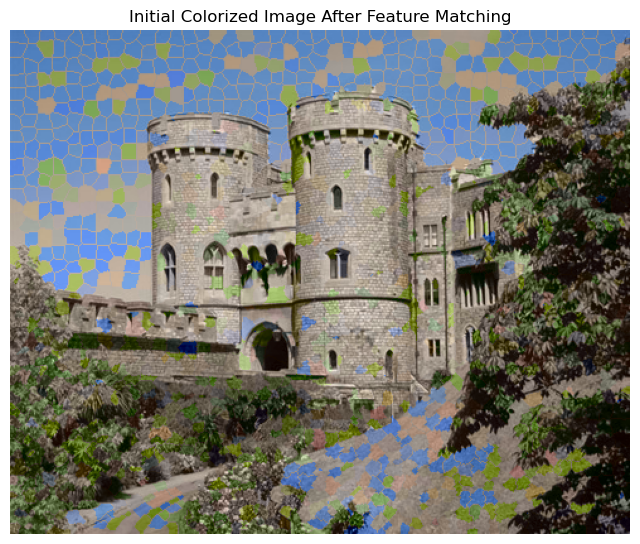

In [37]:
# Function to colorize the target image after feature matching
def colorize_after_matching(target_lab, target_superpixels, matches, reference_lab):
    colorized_image = target_lab.copy()
    for target_idx, ref_idx in matches.items():
        ref_mask = (reference_superpixels == ref_idx)
        ref_pixels = reference_lab[ref_mask, 1:3]  # Get 'a' and 'b' channels
        avg_color = np.mean(ref_pixels, axis=0) if len(ref_pixels) > 0 else [0, 0]

        mask = (target_superpixels == target_idx)
        colorized_image[mask, 1] = avg_color[0]  # 'a' channel
        colorized_image[mask, 2] = avg_color[1]  # 'b' channel

    return colorized_image

# Apply initial colorization after feature matching
initial_colorized_lab = colorize_after_matching(target_lab, target_superpixels, matched_superpixels, reference_lab)

# Visualize the initial colorized image
initial_colorized_rgb = cv2.cvtColor(initial_colorized_lab, cv2.COLOR_Lab2RGB)
initial_colorized_rgb = cv2.cvtColor(initial_colorized_rgb, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(8, 8))
plt.imshow(initial_colorized_rgb)
plt.title("Initial Colorized Image After Feature Matching")
plt.axis('off')
plt.show()